## 1. Regression discontinuity: banking recovery


In [22]:
# Import modules
import pandas as pd
import numpy as np

# Read in dataset
df = pd.read_csv("bank_data.csv")
df.head()

,id,expected_recovery_amount,actual_recovery_amount,recovery_strategy,age,sex
0,2030,194,263.540,Level 0 Recovery,19,Male
1,1150,486,416.090,Level 0 Recovery,25,Female
2,380,527,429.350,Level 0 Recovery,27,Male
3,1838,536,296.990,Level 0 Recovery,25,Male
4,1995,541,346.385,Level 0 Recovery,34,Male


## 2. Graphical exploratory data analysis


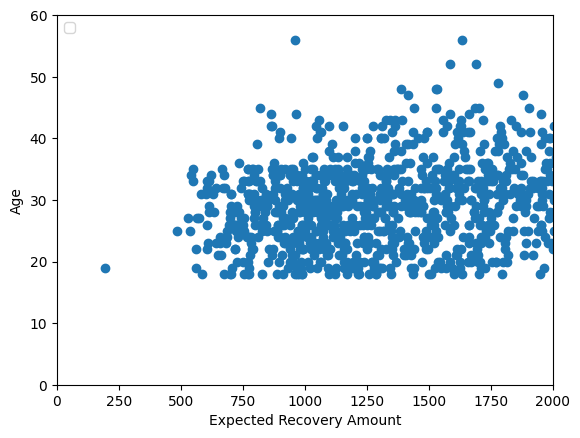

In [23]:
from matplotlib import pyplot as plt
plt.scatter(x=df['expected_recovery_amount'], y=df['age'])
plt.xlim(0, 2000)
plt.ylim(0, 60)
plt.xlabel("Expected Recovery Amount")
plt.ylabel("Age")
plt.legend(loc=2)

## 3. Statistical test:  age vs. expected recovery amount


In [24]:
from scipy import stats

bet_1100_and_900 = df.loc[(df['expected_recovery_amount']<1100) &
                      (df['expected_recovery_amount']>=900)]
by_recovery_strategy = bet_1100_and_900.groupby(['recovery_strategy'])
by_recovery_strategy['age'].describe().unstack()

L0 = bet_1100_and_900.loc[df['recovery_strategy']=="Level 0 Recovery"]['age']
L1 = bet_1100_and_900.loc[df['recovery_strategy']=="Level 1 Recovery"]['age']
stats.kruskal(L0,L1)

KruskalResult(statistic=3.4572342749517513, pvalue=0.06297556896097407)

## 4. Statistical test:  sex vs. expected recovery amount


In [25]:
# Number of customers in each category
crosstab = pd.crosstab(df.loc[(df['expected_recovery_amount']<1100) & (df['expected_recovery_amount']>=900)]['recovery_strategy'], df['sex'])
print(crosstab)
# Chi-square test
chi2_stat, p_val, dof, ex = stats.chi2_contingency(crosstab)
p_val

sex                Female  Male
recovery_strategy              
Level 0 Recovery       32    57
Level 1 Recovery       39    55


0.5377947810444592

## 5. Exploratory graphical analysis: recovery amount


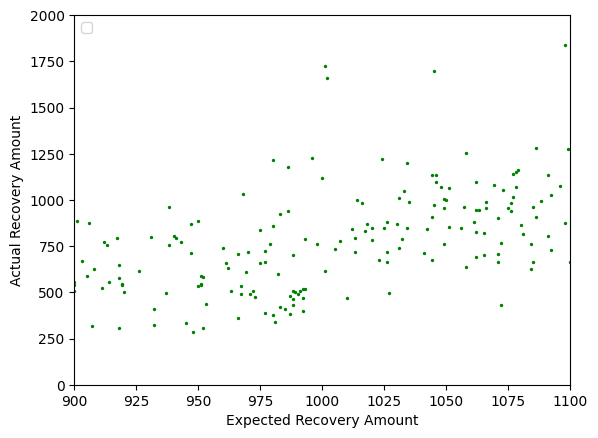

In [26]:
plt.scatter(x=df['expected_recovery_amount'], y=df['actual_recovery_amount'], c="g", s=2)
plt.xlim(900, 1100)
plt.ylim(0, 2000)
plt.xlabel("Expected Recovery Amount")
plt.ylabel("Actual Recovery Amount")
plt.legend(loc=2)
plt.show()

## 6. Statistical analysis:  recovery amount


In [27]:
by_recovery_strategy['actual_recovery_amount'].describe().unstack()

# Perform Kruskal-Wallis test
Level_0_actual = bet_1100_and_900.loc[df['recovery_strategy']=='Level 0 Recovery']['actual_recovery_amount']
Level_1_actual = bet_1100_and_900.loc[df['recovery_strategy']=='Level 1 Recovery']['actual_recovery_amount']
print(stats.kruskal(Level_0_actual,Level_1_actual))

# Repeat for a smaller range of $950 to $1050
era_950_1050 = df.loc[(df['expected_recovery_amount']<1050) &
                      (df['expected_recovery_amount']>=950)]
Level_0_actual = era_950_1050.loc[df['recovery_strategy']=='Level 0 Recovery']['actual_recovery_amount']
Level_1_actual = era_950_1050.loc[df['recovery_strategy']=='Level 1 Recovery']['actual_recovery_amount']

print(stats.kruskal(Level_0_actual,Level_1_actual))

KruskalResult(statistic=65.37966302528878, pvalue=6.177308752803109e-16)
KruskalResult(statistic=30.246000000000038, pvalue=3.80575314300276e-08)


## 7. Regression modeling: no threshold


In [28]:
# Import statsmodels
import statsmodels.api as sm

# Define X and y
X = bet_1100_and_900['expected_recovery_amount']
y = bet_1100_and_900['actual_recovery_amount']
X = sm.add_constant(X)

# Build linear regression model
model = sm.OLS(y, X).fit()
predictions = model.predict(X)

# Print out the model summary statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     actual_recovery_amount   R-squared:                       0.261
Model:                                OLS   Adj. R-squared:                  0.256
Method:                     Least Squares   F-statistic:                     63.78
Date:                    Mon, 02 Oct 2023   Prob (F-statistic):           1.56e-13
Time:                            15:51:07   Log-Likelihood:                -1278.9
No. Observations:                     183   AIC:                             2562.
Df Residuals:                         181   BIC:                             2568.
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                    -1978.7597    347.741     -5.690      0.000   -2664.907   -1292.612
expected_recovery_amount     2.7577      0.345      7.986      0.000       2.076       3.439
==============================================================================
Omnibus:                       64.493   Durbin-Watson:                   1.777
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              185.818
Skew:                           1.463   Prob(JB):                     4.47e-41
Kurtosis:                       6.977   Cond. No.                     1.80e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.8e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## 8. Regression modeling: adding true threshold


In [29]:
# Create indicator (0 or 1) for expected recovery amount >= $1000
df['indicator_1000'] = np.where(df['expected_recovery_amount']<100, 0, 1)
era_900_1100 = df.loc[(df['expected_recovery_amount']<1100) &
                      (df['expected_recovery_amount']>=900)]

# Define X and y
X = era_900_1100[['expected_recovery_amount', 'indicator_1000']]
y = era_900_1100['actual_recovery_amount']
X = sm.add_constant(X)

# Build linear regression model
model = sm.OLS(y,X).fit()

# Print the model summary
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     actual_recovery_amount   R-squared:                       0.261
Model:                                OLS   Adj. R-squared:                  0.256
Method:                     Least Squares   F-statistic:                     63.78
Date:                    Mon, 02 Oct 2023   Prob (F-statistic):           1.56e-13
Time:                            15:51:07   Log-Likelihood:                -1278.9
No. Observations:                     183   AIC:                             2562.
Df Residuals:                         181   BIC:                             2568.
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
expected_recovery_amount     2.7577      0.345      7.986      0.000       2.076       3.439
indicator_1000           -1978.7597    347.741     -5.690      0.000   -2664.907   -1292.612
==============================================================================
Omnibus:                       64.493   Durbin-Watson:                   1.777
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              185.818
Skew:                           1.463   Prob(JB):                     4.47e-41
Kurtosis:                       6.977   Cond. No.                     1.80e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.8e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## 9. Regression modeling: adjusting the window


In [30]:
# Redefine era_950_1050 so the indicator variable is included
era_950_1050 = df.loc[(df['expected_recovery_amount']<1050) &
                      (df['expected_recovery_amount']>=950)]

# Define X and y
X = era_950_1050[['expected_recovery_amount','indicator_1000']]
y = era_950_1050['actual_recovery_amount']
X = sm.add_constant(X)

# Build linear regression model
model = sm.OLS(y,X).fit()

# Print the model summary
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     actual_recovery_amount   R-squared:                       0.234
Model:                                OLS   Adj. R-squared:                  0.226
Method:                     Least Squares   F-statistic:                     29.64
Date:                    Mon, 02 Oct 2023   Prob (F-statistic):           3.92e-07
Time:                            15:51:07   Log-Likelihood:                -696.22
No. Observations:                      99   AIC:                             1396.
Df Residuals:                          97   BIC:                             1402.
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
expected_recovery_amount     5.1555      0.947      5.444      0.000       3.276       7.035
indicator_1000           -4381.7808    946.452     -4.630      0.000   -6260.226   -2503.336
==============================================================================
Omnibus:                       44.345   Durbin-Watson:                   1.845
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              108.727
Skew:                           1.681   Prob(JB):                     2.46e-24
Kurtosis:                       6.879   Cond. No.                     3.40e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.4e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""